# Electrode position preprocessing 

To make position estimates of the electrode grid useful for behavioral analysis, it has to be cleaned first. In this notebook, we will go over how the function `smooth_positions` cleans position estimates. Additionally, the notebook can be used to explore the parameters that can be adjusted in the configuration file of the `datacleaner`, the main module that applies position smoothing. As a first step, let's load some data.

[ GridTracks.__init__ ] No grid metadata found in directory ../output/2016-04-20-18_49/


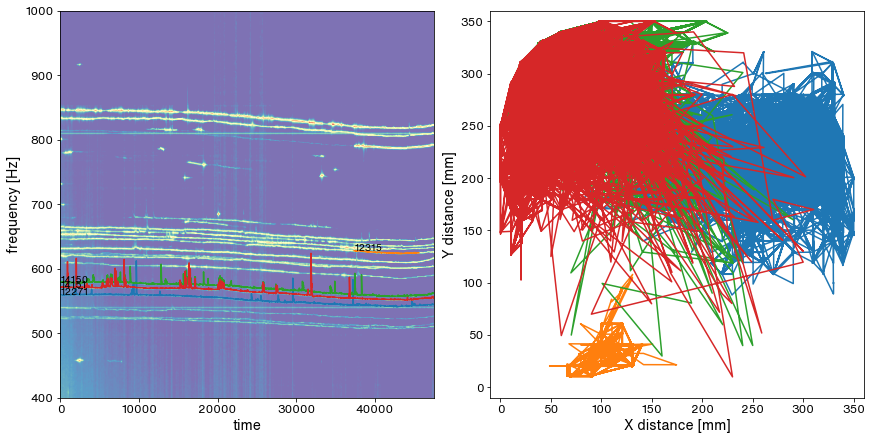

In [3]:
import numpy as np
from termcolors import TermColor as tc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gridtools as gt
from gridtools import utils as fs
from scipy.signal import medfilt, savgol_filter
from plotstyle import PlotStyle

# uncomment to plot to seperate windows:
# %matplotlib qt

s = PlotStyle()
path = "../output/2016-04-20-18_49/"
grid = gt.GridTracks(path, finespec=False, verbose=False)

# plot the dataset and choose a cool frequency track id to work on
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), constrained_layout=True)
grid.plot_spec(ax1)
grid.plot_pos(ax2, legend=False, smoothed=False)

After a track ID is chosen, we can isolate the track using a monad and visualize the position estimates for the track ID. Additionally, I will compute the velocity of the fish at a given time and visualize the x and y coordinate and the velocity seperately from the grid.

In [4]:
track_id = 14150
m = gt.Monad(grid, track_id, verbose=False)

# velocity
v = fs.velocity2d(m.times, m.xpos, m.ypos)

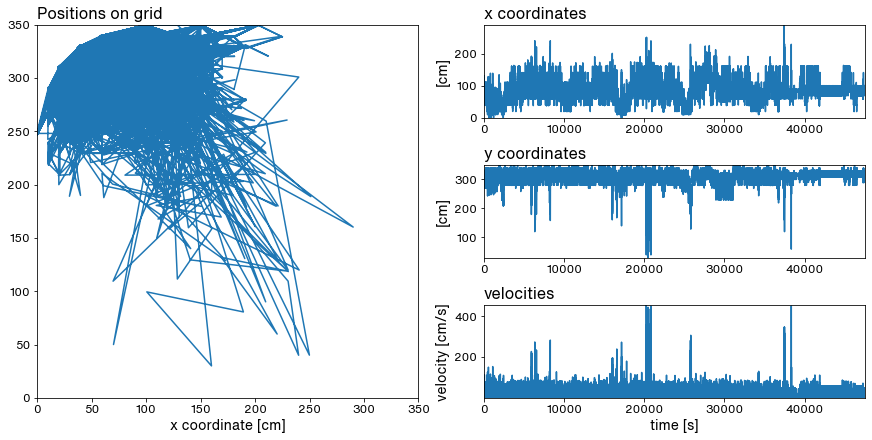

In [5]:
# function to make plotting easier in the future
def coordinate_overview():
    fig = plt.figure(constrained_layout=True, figsize= (12,6))
    spec = gridspec.GridSpec(ncols=6, nrows=3, figure=fig)
    ax1 = fig.add_subplot(spec[0:3, 0:3])
    ax2 = fig.add_subplot(spec[0, 3:6])
    ax3 = fig.add_subplot(spec[1, 3:6], sharex = ax2)
    ax4 = fig.add_subplot(spec[2, 3:6], sharex = ax2)

    ax1.set_xlim(0,350)
    ax1.set_ylim(0,350)
    
    ax1.set_title('Positions on grid')
    ax2.set_title('x coordinates')
    ax3.set_title('y coordinates')
    ax4.set_title('velocities')
    ax1.set_xlabel('x coordinate [cm]')
    ax4.set_xlabel('time [s]')
    ax2.set_ylabel('[cm]')
    ax3.set_ylabel('[cm]')
    ax4.set_ylabel('velocity [cm/s]')

    return ax1,ax2,ax3,ax4

# plot coordinates
ax1,ax2,ax3,ax4 = coordinate_overview()
ax1.plot(m.xpos, m.ypos)
ax2.plot(m.times, m.xpos)
ax3.plot(m.times, m.ypos)
ax4.plot(m.times, v)

We see that the position estimates on the grid have jagged edges, sharp turns and are very jumpy overall. The reason for this is, that position is estimated on a limited number of electrodes with large spacing 50 cm. If, from one time point to another, another electrode enters the maximum power range, the position estimate jumps into the direction of this electrode. Additionally, frequency modulations of the fish and tracking errors introduce coordinates that would only be explained by fish traveling speeds of 1 m/s or more, which is probably unrealistic. Three processing steps solve these problems:

1. Velocity filter: Removes datapoints that requires the fish to exceed an unrealistic travel speed threshold.
2. Median filter: Removes jumpyness due to electrode weighting on a realistic spatial scale.
3. Savitzky-Golay filter: Smoothes the remaining position tracks to produce "natural" movements.

All three steps successively remove information from the dataset. Adjusting the parameters in subjective and should be done with caution! If the threshold is too low, fast movements such as chasing may be removed. If smoothing is too stong, small movements are lost as well. Preprocessing steps were chosen based on [Rajan Gupte et al. 2021](https://doi.org/10.1111/1365-2656.13610).

First we will take a look at the animal speed across the full dataset during its active period. Including resting periods would skew the distribution towards slower speeds. To get the active period only, I discard all datapoints that were collected during the day, by thresholding the light array. A speed threshold will be established by a percentile of the animal velocity distribution across its active period.

computed AreaUnderCurve (AUC) of KDE using sklearn.metrics.auc: 0.8624818061013109
Cutoff velocity at 99 percentile: 72.34756911205879


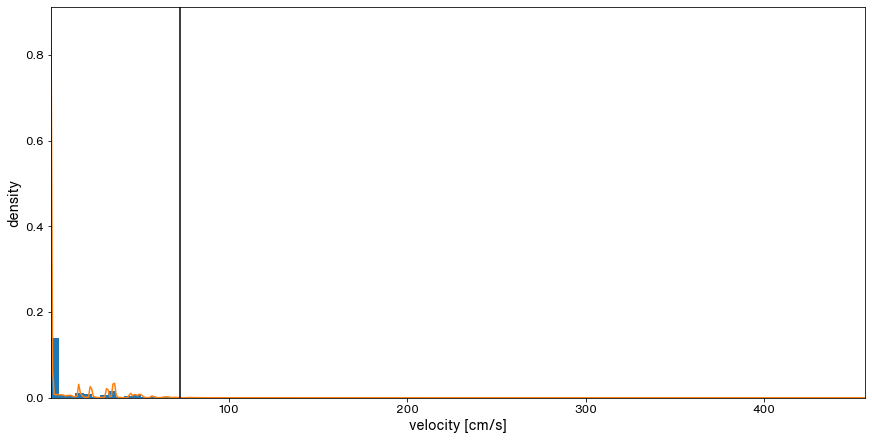

In [12]:
# compute all velocities
perc_thresh = 99 # percentile speed threshold
light_tresh = 25 # light threshold to det. active period
grid_vs = []

for track_id in grid.ids:
    
    # get data
    t = grid.times[grid.idx_v[grid.ident_v == track_id]]
    light = grid.light[grid.idx_v[grid.ident_v == track_id]]
    x = grid.xpos[grid.ident_v == track_id]
    y = grid.ypos[grid.ident_v == track_id]

    # filter active period
    t_active = t[light < light_tresh]
    x_active = x[light < light_tresh]
    y_active = y[light < light_tresh]

    # compute velocities
    grid_v = fs.velocity2d(t_active,x_active,y_active)
    
    # collect velocities
    grid_vs.extend(grid_v.tolist())

# remove nans from padding
grid_vs = np.array(grid_vs)[~np.isnan(grid_vs)]

# plot kernel density, hist, thresh
kde = fs.kde1d(grid_vs, 0.1)
fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
ax.hist(grid_vs, bins=100, density=True)    # plot hist
ax.plot(kde[0], kde[1])                     # plot kde
ax.axvline(np.percentile(grid_vs, perc_thresh), color = 'black') # plot thresh
ax.set_xlabel('velocity [cm/s]')
ax.set_ylabel('density')

# print threshold
print(f'Cutoff velocity at {perc_thresh} percentile: ' + tc.succ(f'{np.percentile(grid_vs, perc_thresh)}'))

In this case, I chose the 95 percentile which yielded a cutoff velocity of abput 45 cm/s. Now we can proceed by applying this threshold to the velocities of the single individual we worked with.

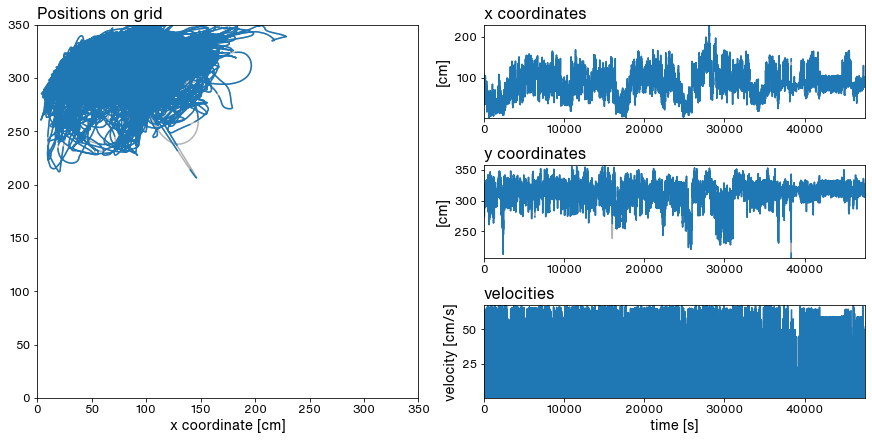

In [13]:
vcutoff = 68

# save old arrays for future comparison
import copy
xpos_raw = copy.deepcopy(m.xpos)
ypos_raw = copy.deepcopy(m.ypos)
v_raw = copy.deepcopy(v)

# thresholding
v[v > vcutoff] = np.nan

# get indices for the position coordinates where v is too large
index = np.arange(len(m.xpos))
nans = index[np.isnan(v)]

# delete coordinates where v is too large
m.xpos[nans] = np.nan
m.ypos[nans] = np.nan

# plot result
ax1, ax2, ax3, ax4 = coordinate_overview()
ax1.plot(xpos_raw, ypos_raw, alpha = 0.3, color = "black") # old coordinates
ax1.plot(m.xpos, m.ypos)
ax2.plot(m.times, xpos_raw, alpha = 0.3, color = 'black')
ax2.plot(m.times, m.xpos)
ax3.plot(m.times, ypos_raw, alpha = 0.3, color = 'black')
ax3.plot(m.times, m.ypos)
ax4.plot(m.times, v_raw, alpha = 0.3, color = 'black')
ax4.plot(m.times, v)

# stash non-interpolated for plotting
xpos_threshd = copy.deepcopy(m.xpos)
ypos_threshd = copy.deepcopy(m.ypos)

The remaining datapoints are now all within a rang of the determined 'realistic' travel speed. Since this procedure removed datapoints, we now need to interpolate these datapoints to filter them. In the following plot, the non-interpolated, but thresholded datapoints are plotted ontop of the interpolated datapoints.

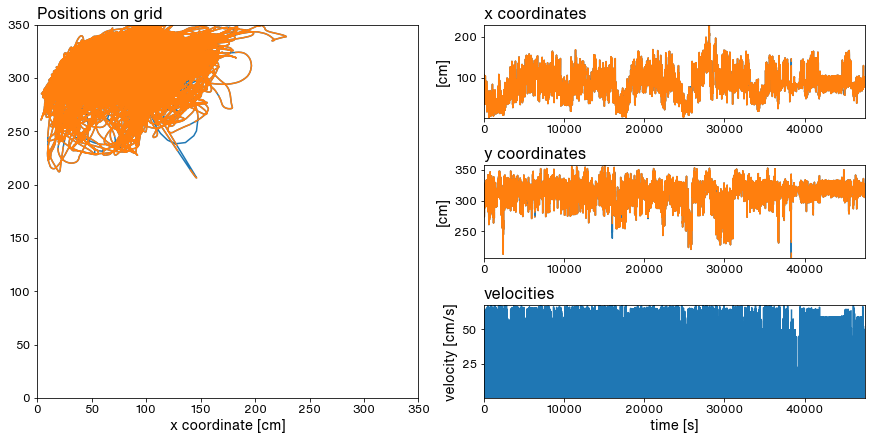

In [14]:
# interpolate position coordinates
m.xpos = np.interp(m.times, m.times[~np.isnan(m.xpos)], m.xpos[~np.isnan(m.xpos)])
m.ypos = np.interp(m.times, m.times[~np.isnan(m.ypos)], m.ypos[~np.isnan(m.ypos)])

# plot non-interpolated ontop of interpolated
ax1, ax2, ax3, ax4 = coordinate_overview()
ax1.plot(m.xpos, m.ypos)
ax1.plot(xpos_threshd, ypos_threshd)
ax2.plot(m.times, m.xpos)
ax2.plot(m.times, xpos_threshd)
ax3.plot(m.times, m.ypos)
ax3.plot(m.times, ypos_threshd)
ax4.plot(m.times, v)

# stash interpolated for plotting
xpos_threshd_interp = copy.deepcopy(m.xpos)
ypos_threshd_interp = copy.deepcopy(m.ypos)

As we can see, interpolating re-introduces some outliers again. In some cases, the positin estimates have maxima at false electrodes, e.g. because there is a fish of similar frequency somewhere else on the grid, or the fish crosses the frequency of another. If these errors are of long enough durations, the travel speed to the outlier and back to the correct estimates might be removed by the threshold, but the points during the false position estimates remain, and are reconnected to the rest by interpolation. To minize the effect of these datapoints, we can apply a median filter. The kernel size of the median filter determines, how many data points before and after a single point are take into consideration, when computing the median. The larger the kernel, the more information is lost and the smoother the signal.

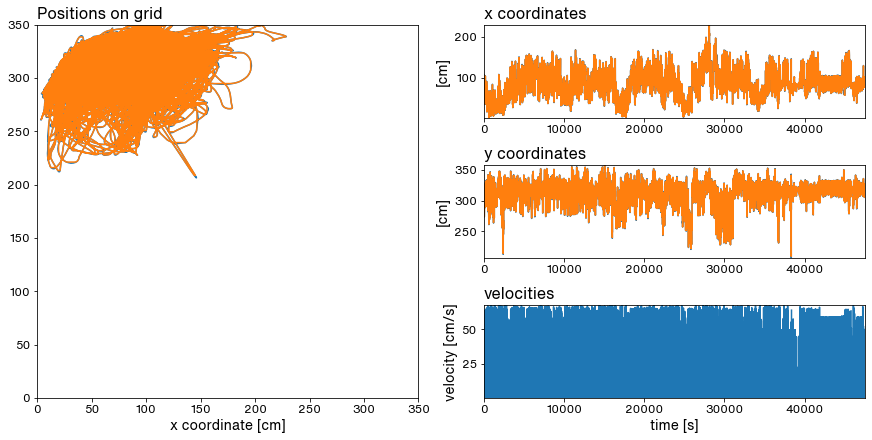

In [15]:
# filter
med_window = 9 # must be odd
m.xpos = medfilt(m.xpos, kernel_size=med_window)
m.ypos = medfilt(m.ypos, kernel_size=med_window)

# plot median filtered on top of interpolated
ax1, ax2, ax3, ax4 = coordinate_overview()
ax1.plot(xpos_threshd_interp, ypos_threshd_interp)
ax1.plot(m.xpos, m.ypos)
ax2.plot(m.times, xpos_threshd_interp)
ax2.plot(m.times, m.xpos)
ax3.plot(m.times, ypos_threshd_interp)
ax3.plot(m.times, m.ypos)
ax4.plot(m.times, v)

# stash data for plotting
xpos_threshd_interp_medfilt = copy.deepcopy(m.xpos)
ypos_threshd_interp_medfilt = copy.deepcopy(m.ypos)

Again, some outliers where removed and the positions are somewhat smoother than before. Ultimately, we cannot determine, which movements are outliers and which movements are realistic. 

The position estimates are still jumpy, which is a feature that is most likely produced by the large electrode spacing. To remove this, we can apply a smoothing filter. The Savitzky Golay filter fits a polynomial of nth order to data range of a given window size.

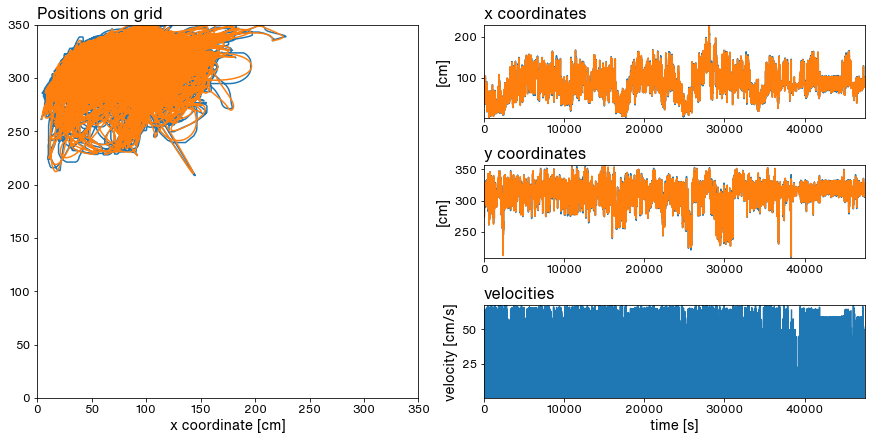

In [16]:
# filter
smth_window = 100
poly = 6
m.xpos = savgol_filter(m.xpos, smth_window, poly)
m.ypos = savgol_filter(m.ypos, smth_window, poly)

# plot smoothed on top of thresholded, interpolated, median filtered
ax1, ax2, ax3, ax4 = coordinate_overview()
ax1.plot(xpos_threshd_interp_medfilt, ypos_threshd_interp_medfilt)
ax1.plot(m.xpos, m.ypos)
ax2.plot(m.times, xpos_threshd_interp_medfilt)
ax2.plot(m.times, m.xpos)
ax3.plot(m.times, ypos_threshd_interp_medfilt)
ax3.plot(m.times, m.ypos)
ax4.plot(m.times, v)

To round it off, lets compare the completely processed results to the raw data and print the processing parameters we used. Now you have to play with the parameters until the position estimates 'feel realistic'.

I came up with the following parameters:

- Velocity threshold: 68 cm/s
- Median filter kernel size: 9
- Savitzky-Golay filter polynomial order: 6
- Savitzky-Golay filter kernel size: 100

Final note: A parameter not discussed in this notebook is the number of electrodes used to determine the position estimates. Position estimates are always warped, because there are no electrodes outside the grid. For more realistic position estimates, there should be at least two rows of electrodes outside of the field the fish is tracked in. In this case, where all grid electrodes where used to estimate positions, the electrode number is subject to a central tradeoff: The lower the number of electrodes, the higher the amount of jumps in the estimates and the lower the precision. The higher the number of electrodes, the stronger all datapoints will be pulled into the center of the grid, ultimately resulting in a circular cloud of position estimates. In future iteration of grid position estimates, one should quantify tracking precision and warping to find the optimal number of electrodes for estimation. Ultimatley, the best solution would be to only use 16 electrodes in the center of a 64 electrode square grid.

Velocity threshold: 68 cm/s
Median filter kernel size: 9
Savitzky-Golay filter polynomial order: 6
Savitzky-Golay filter kernel size: 100


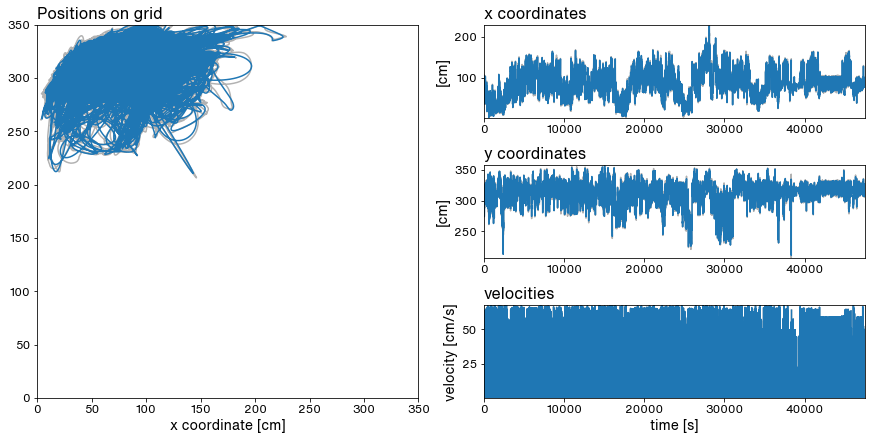

In [17]:
# plot result
ax1, ax2, ax3, ax4 = coordinate_overview()
ax1.plot(xpos_raw, ypos_raw, alpha = 0.3, color = "black") # old coordinates
ax1.plot(m.xpos, m.ypos)
ax2.plot(m.times, xpos_raw, alpha = 0.3, color = 'black')
ax2.plot(m.times, m.xpos)
ax3.plot(m.times, ypos_raw, alpha = 0.3, color = 'black')
ax3.plot(m.times, m.ypos)
ax4.plot(m.times, v_raw, alpha = 0.3, color = 'black')
ax4.plot(m.times, v)

# print params
print('Velocity threshold: ' + tc.succ(f'{vcutoff}') + ' cm/s')
print('Median filter kernel size: ' + tc.succ(f'{med_window}'))
print('Savitzky-Golay filter polynomial order: ' + tc.succ(f'{poly}'))
print('Savitzky-Golay filter kernel size: ' + tc.succ(f'{smth_window}'))